In [1]:
%matplotlib notebook


# TEM: ABEM WalkTEM

The modeller ``empymod`` models the electromagnetic (EM) full wavefield Greens
function for electric and magnetic point sources and receivers. As such, it can
model any EM method from DC to GPR. However, how to actually implement a
particular EM method and survey layout can be tricky, as there are many more
things involved than just computing the EM Greens function.

**In this example we are going to compute a TEM response, in particular from
the system** `WalkTEM <https://www.guidelinegeo.com>`_,
and compare it with data obtained from `AarhusInv
<https://hgg.au.dk/software/aarhusinv>`_. However, you can use and adapt this
example to model other TEM systems, such as skyTEM, SIROTEM, TEM-FAST, or any
other system.

What is not included in ``empymod`` at this moment (but hopefully in the
future), but is required to model TEM data, is to **account for arbitrary
source waveform**, and to apply a **lowpass filter**. So we generate these two
things here, and create our own wrapper to model TEM data.

The incentive for this example came from Leon Foks (`@leonfoks
<https://github.com/leonfoks>`_) for `GeoBIPy
<https://github.com/usgs/geobipy>`_, and it was created with his help and also
the help of Seogi Kang (`@sgkang <https://github.com/sgkang>`_) from
`simpegEM1D <https://github.com/simpeg/simpegem1d>`_; the waveform function is
based on work from Kerry Key (`@kerrykey <https://github.com/kerrykey>`_) from
`emlab <https://emlab.ldeo.columbia.edu>`_.


In [2]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
plt.style.use('ggplot')

## 1. AarhusInv data

The comparison data was created by Leon Foks using AarhusInv.

### Off times (when measurement happens)



In [3]:
# Low moment
lm_off_time = np.array([
    1.149E-05, 1.350E-05, 1.549E-05, 1.750E-05, 2.000E-05, 2.299E-05,
    2.649E-05, 3.099E-05, 3.700E-05, 4.450E-05, 5.350E-05, 6.499E-05,
    7.949E-05, 9.799E-05, 1.215E-04, 1.505E-04, 1.875E-04, 2.340E-04,
    2.920E-04, 3.655E-04, 4.580E-04, 5.745E-04, 7.210E-04
])

# High moment
hm_off_time = np.array([
    9.810e-05, 1.216e-04, 1.506e-04, 1.876e-04, 2.341e-04, 2.921e-04,
    3.656e-04, 4.581e-04, 5.746e-04, 7.211e-04, 9.056e-04, 1.138e-03,
    1.431e-03, 1.799e-03, 2.262e-03, 2.846e-03, 3.580e-03, 4.505e-03,
    5.670e-03, 7.135e-03
])

### Data resistive model



In [4]:
# Low moment
lm_aarhus_res = np.array([
    7.980836E-06, 4.459270E-06, 2.909954E-06, 2.116353E-06, 1.571503E-06,
    1.205928E-06, 9.537814E-07, 7.538660E-07, 5.879494E-07, 4.572059E-07,
    3.561824E-07, 2.727531E-07, 2.058368E-07, 1.524225E-07, 1.107586E-07,
    7.963634E-08, 5.598970E-08, 3.867087E-08, 2.628711E-08, 1.746382E-08,
    1.136561E-08, 7.234771E-09, 4.503902E-09
])

# High moment
hm_aarhus_res = np.array([
    1.563517e-07, 1.139461e-07, 8.231679e-08, 5.829438e-08, 4.068236e-08,
    2.804896e-08, 1.899818e-08, 1.268473e-08, 8.347439e-09, 5.420791e-09,
    3.473876e-09, 2.196246e-09, 1.372012e-09, 8.465165e-10, 5.155328e-10,
    3.099162e-10, 1.836829e-10, 1.072522e-10, 6.161256e-11, 3.478720e-11
])

### Data conductive model



In [5]:
# Low moment
lm_aarhus_con = np.array([
    1.046719E-03, 7.712241E-04, 5.831951E-04, 4.517059E-04, 3.378510E-04,
    2.468364E-04, 1.777187E-04, 1.219521E-04, 7.839379E-05, 4.861241E-05,
    2.983254E-05, 1.778658E-05, 1.056006E-05, 6.370305E-06, 3.968808E-06,
    2.603794E-06, 1.764719E-06, 1.218968E-06, 8.483796E-07, 5.861686E-07,
    3.996331E-07, 2.678636E-07, 1.759663E-07
])

# High moment
hm_aarhus_con = np.array([
    6.586261e-06, 4.122115e-06, 2.724062e-06, 1.869149e-06, 1.309683e-06,
    9.300854e-07, 6.588088e-07, 4.634354e-07, 3.228131e-07, 2.222540e-07,
    1.509422e-07, 1.010134e-07, 6.662953e-08, 4.327995e-08, 2.765871e-08,
    1.738750e-08, 1.073843e-08, 6.512053e-09, 3.872709e-09, 2.256841e-09
])

### WalkTEM Waveform and other characteristics



<IPython.core.display.Javascript object>


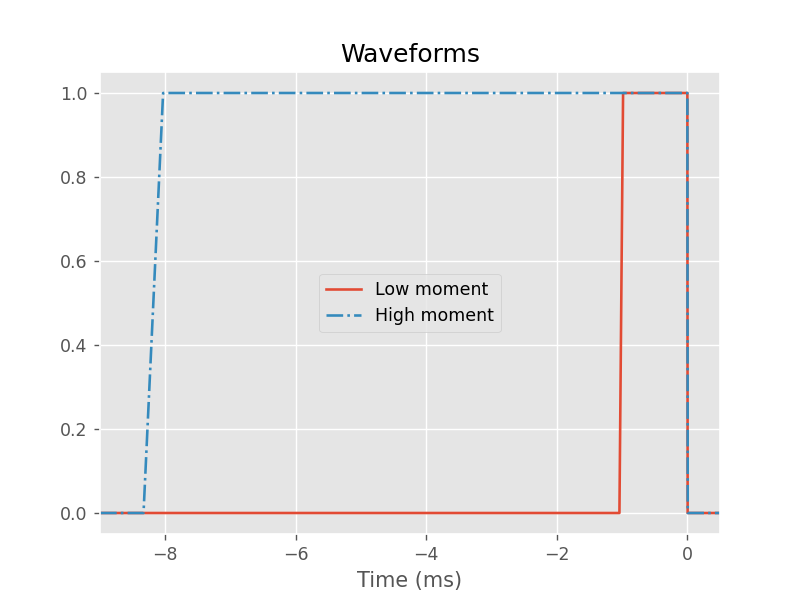

In [6]:
# Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Time (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

## 2. ``empymod`` implementation



In [7]:
def waveform(times, resp, times_wanted, wave_time, wave_amp, nquad=3):
    """Apply a source waveform to the signal.

    Parameters
    ----------
    times : ndarray
        Times of computed input response; should start before and end after
        `times_wanted`.

    resp : ndarray
        EM-response corresponding to `times`.

    times_wanted : ndarray
        Wanted times.

    wave_time : ndarray
        Time steps of the wave.

    wave_amp : ndarray
        Amplitudes of the wave corresponding to `wave_time`, usually
        in the range of [0, 1].

    nquad : int
        Number of Gauss-Legendre points for the integration. Default is 3.

    Returns
    -------
    resp_wanted : ndarray
        EM field for `times_wanted`.

    """

    # Interpolate on log.
    PP = iuSpline(np.log10(times), resp)

    # Wave time steps.
    dt = np.diff(wave_time)
    dI = np.diff(wave_amp)
    dIdt = dI/dt

    # Gauss-Legendre Quadrature; 3 is generally good enough.
    # (Roots/weights could be cached.)
    g_x, g_w = roots_legendre(nquad)

    # Pre-allocate output.
    resp_wanted = np.zeros_like(times_wanted)

    # Loop over wave segments.
    for i, cdIdt in enumerate(dIdt):

        # We only have to consider segments with a change of current.
        if cdIdt == 0.0:
            continue

        # If wanted time is before a wave element, ignore it.
        ind_a = wave_time[i] < times_wanted
        if ind_a.sum() == 0:
            continue

        # If wanted time is within a wave element, we cut the element.
        ind_b = wave_time[i+1] > times_wanted[ind_a]

        # Start and end for this wave-segment for all times.
        ta = times_wanted[ind_a]-wave_time[i]
        tb = times_wanted[ind_a]-wave_time[i+1]
        tb[ind_b] = 0.0  # Cut elements

        # Gauss-Legendre for this wave segment. See
        # https://en.wikipedia.org/wiki/Gaussian_quadrature#Change_of_interval
        # for the change of interval, which makes this a bit more complex.
        logt = np.log10(np.outer((tb-ta)/2, g_x)+(ta+tb)[:, None]/2)
        fact = (tb-ta)/2*cdIdt
        resp_wanted[ind_a] += fact*np.sum(np.array(PP(logt)*g_w), axis=1)

    return resp_wanted

In [8]:
def get_time(time, r_time):
    """Additional time for ramp.

    Because of the arbitrary waveform, we need to compute some times before and
    after the actually wanted times for interpolation of the waveform.

    Some implementation details: The actual times here don't really matter. We
    create a vector of time.size+2, so it is similar to the input times and
    accounts that it will require a bit earlier and a bit later times. Really
    important are only the minimum and maximum times. The Fourier DLF, with
    `pts_per_dec=-1`, computes times from minimum to at least the maximum,
    where the actual spacing is defined by the filter spacing. It subsequently
    interpolates to the wanted times. Afterwards, we interpolate those again to
    compute the actual waveform response.

    Note: We could first call `waveform`, and get the actually required times
          from there. This would make this function obsolete. It would also
          avoid the double interpolation, first in `empymod.model.time` for the
          Fourier DLF with `pts_per_dec=-1`, and second in `waveform`. Doable.
          Probably not or marginally faster. And the code would become much
          less readable.

    Parameters
    ----------
    time : ndarray
        Desired times

    r_time : ndarray
        Waveform times

    Returns
    -------
    time_req : ndarray
        Required times
    """
    tmin = np.log10(max(time.min()-r_time.max(), 1e-10))
    tmax = np.log10(time.max()-r_time.min())
    return np.logspace(tmin, tmax, time.size+2)

In [9]:
def walktem(moment, depth, res):
    """Custom wrapper of empymod.model.bipole.

    Here, we compute WalkTEM data using the ``empymod.model.bipole`` routine as
    an example. We could achieve the same using ``empymod.model.dipole`` or
    ``empymod.model.loop``.

    We model the big source square loop by computing only half of one side of
    the electric square loop and approximating the finite length dipole with 3
    point dipole sources. The result is then multiplied by 8, to account for
    all eight half-sides of the square loop.

    The implementation here assumes a central loop configuration, where the
    receiver (1 m2 area) is at the origin, and the source is a 40x40 m electric
    loop, centered around the origin.

    Note: This approximation of only using half of one of the four sides
          obviously only works for central, horizontal square loops. If your
          loop is arbitrary rotated, then you have to model all four sides of
          the loop and sum it up.


    Parameters
    ----------
    moment : str {'lm', 'hm'}
        Moment. If 'lm', above defined ``lm_off_time``, ``lm_waveform_times``,
        and ``lm_waveform_current`` are used. Else, the corresponding
        ``hm_``-parameters.

    depth : ndarray
        Depths of the resistivity model (see ``empymod.model.bipole`` for more
        info.)

    res : ndarray
        Resistivities of the resistivity model (see ``empymod.model.bipole``
        for more info.)

    Returns
    -------
    WalkTEM : EMArray
        WalkTEM response (dB/dt).

    """

    # Get the measurement time and the waveform corresponding to the provided
    # moment.
    if moment == 'lm':
        off_time = lm_off_time
        waveform_times = lm_waveform_times
        waveform_current = lm_waveform_current
    elif moment == 'hm':
        off_time = hm_off_time
        waveform_times = hm_waveform_times
        waveform_current = hm_waveform_current
    else:
        raise ValueError("Moment must be either 'lm' or 'hm'!")

    # === GET REQUIRED TIMES ===
    time = get_time(off_time, waveform_times)

    # === GET REQUIRED FREQUENCIES ===
    time, freq, ft, ftarg = empymod.utils.check_time(
        time=time,          # Required times
        signal=1,           # Switch-on response
        ft='dlf',           # Use DLF
        ftarg={'dlf': 'key_81_CosSin_2009'},  # Short, fast filter; if you
        verb=2,                 # need higher accuracy choose a longer filter.
    )

    # === COMPUTE FREQUENCY-DOMAIN RESPONSE ===
    # We only define a few parameters here. You could extend this for any
    # parameter possible to provide to empymod.model.bipole.
    EM = empymod.model.bipole(
        src=[20, 20,   0, 20, 0, 0],  # El. bipole source; half of one side.
        rec=[0, 0, 0, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0, depth],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=8,                   # To account for 4 sides of square loop.
        srcpts=3,                     # Approx. the finite dip. with 3 points.
        htarg={'dlf': 'key_101_2009'},  # Short filter, so fast.
    )

    # Multiply the frequecny-domain result with
    # \mu for H->B, and i\omega for B->dB/dt.
    EM *= 2j*np.pi*freq*4e-7*np.pi

    # === Butterworth-type filter (implemented from simpegEM1D.Waveforms.py)===
    # Note: Here we just apply one filter. But it seems that WalkTEM can apply
    #       two filters, one before and one after the so-called front gate
    #       (which might be related to ``delay_rst``, I am not sure about that
    #       part.)
    cutofffreq = 4.5e5               # As stated in the WalkTEM manual
    h = (1+1j*freq/cutofffreq)**-1   # First order type
    h *= (1+1j*freq/3e5)**-1
    EM *= h

    # === CONVERT TO TIME DOMAIN ===
    delay_rst = 1.8e-7               # As stated in the WalkTEM manual
    EM, _ = empymod.model.tem(EM[:, None], np.array([1]),
                              freq, time+delay_rst, 1, ft, ftarg)
    EM = np.squeeze(EM)

    # === APPLY WAVEFORM ===
    return waveform(time, EM, off_time, waveform_times, waveform_current)

## 3. Computation



In [15]:
# Compute resistive model
lm_empymod_res = walktem('lm', depth=[75], res=[500, 20])
hm_empymod_res = walktem('hm', depth=[75], res=[500, 20])

# Compute conductive model
lm_empymod_con = walktem('lm', depth=[30], res=[10, 1])
hm_empymod_con = walktem('hm', depth=[30], res=[10, 1])


:: empymod END; runtime = 0:00:00.007650 :: 3 kernel call(s)


:: empymod END; runtime = 0:00:00.007763 :: 3 kernel call(s)


:: empymod END; runtime = 0:00:00.007403 :: 3 kernel call(s)


:: empymod END; runtime = 0:00:00.007805 :: 3 kernel call(s)



## 4. Comparison



<IPython.core.display.Javascript object>


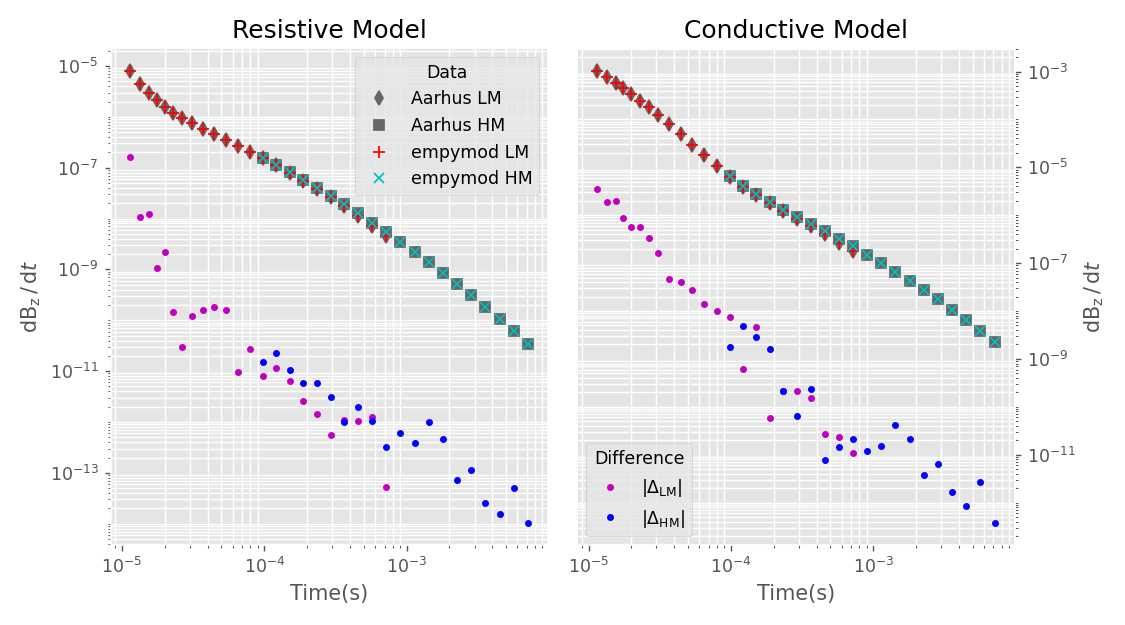

In [13]:
plt.figure(figsize=(9, 5))

# Plot result resistive model
ax1 = plt.subplot(121)
plt.title('Resistive Model')

# AarhusInv
plt.plot(lm_off_time, lm_aarhus_res, 'd', mfc='.4', mec='.4',
         label="Aarhus LM")
plt.plot(hm_off_time, hm_aarhus_res, 's', mfc='.4', mec='.4',
         label="Aarhus HM")

# empymod
plt.plot(lm_off_time, lm_empymod_res, 'r+', ms=7, label="empymod LM")
plt.plot(hm_off_time, hm_empymod_res, 'cx', label="empymod HM")

# Difference
plt.plot(lm_off_time, np.abs((lm_aarhus_res - lm_empymod_res)), 'm.')
plt.plot(hm_off_time, np.abs((hm_aarhus_res - hm_empymod_res)), 'b.')

# Plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time(s)")
plt.ylabel(r"$\mathrm{d}\mathrm{B}_\mathrm{z}\,/\,\mathrm{d}t$")
plt.grid(which='both', c='w')
plt.legend(title='Data', loc=1)

# Plot result conductive model
ax2 = plt.subplot(122)
plt.title('Conductive Model')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# AarhusInv
plt.plot(lm_off_time, lm_aarhus_con, 'd', mfc='.4', mec='.4')
plt.plot(hm_off_time, hm_aarhus_con, 's', mfc='.4', mec='.4')

# empymod
plt.plot(lm_off_time, lm_empymod_con, 'r+', ms=7)
plt.plot(hm_off_time, hm_empymod_con, 'cx')

# Difference
plt.plot(lm_off_time, np.abs((lm_aarhus_con - lm_empymod_con)), 'm.',
         label=r"$|\Delta_\mathrm{LM}|$")
plt.plot(hm_off_time, np.abs((hm_aarhus_con - hm_empymod_con)), 'b.',
         label=r"$|\Delta_\mathrm{HM}|$")

# Plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time(s)")
plt.ylabel(r"$\mathrm{d}\mathrm{B}_\mathrm{z}\,/\,\mathrm{d}t$")
plt.legend(title='Difference', loc=3)

# Force minor ticks on logscale
ax1.yaxis.set_minor_locator(LogLocator(subs='all', numticks=20))
ax2.yaxis.set_minor_locator(LogLocator(subs='all', numticks=20))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax2.yaxis.set_minor_formatter(NullFormatter())
plt.grid(which='both', c='w')

# Finish off
plt.tight_layout()
plt.show()

In [ ]:
empymod.Report()